In [1]:
import SimpleITK as sitk
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from mrio import dicom_reader,nifti_reader
from models.roi import create_rois, ROI  # Import create_rois and ROI class
from fitting.relaxation_fitting import RelaxationFittingModel
from process import transform,transform_mask,SignalFilter,merge_masks_select_rois
from fitting.analysis import compute_roi_statistics
from visualization.mapplot import (
    show_slice,
    show_mask,
    show_parameter_map_with_rois,
    show_rois_with_mean,
)

In [2]:
#mask
input_mask_file= '/home/gizmoo/Desktop/players_T1/P15/P15_T1l_Maske.nii.gz'

#6_t2_de3d
input_dicom_folder_1 = '/home/gizmoo/Desktop/players_T1/P15/PHockey_15_T1_l/DICOM_translated/MRTC-Studie_Hockey_15_GAPF76309/20211213_1413/6_t2_de3d_we_cor_31306'

#7_T2-star_map
input_dicom_folder_T2_Star = '/home/gizmoo/Desktop/players_T1/P15/PHockey_15_T1_l/DICOM_translated/MRTC-Studie_Hockey_15_GAPF76309/20211213_1413/7_T2-star_map_3D_cor_32667'

#14_T2_map
input_dicom_folder_T2 = '/home/gizmoo/Desktop/players_T1/P15/PHockey_15_T1_l/DICOM_translated/MRTC-Studie_Hockey_15_GAPF76309/20211213_1413/14_T2_map_48slc_37306'

#10_T1rho---
sl1 = '/home/gizmoo/Desktop/players_T1/P15/PHockey_15_T1_l/DICOM_translated/MRTC-Studie_Hockey_15_GAPF76309/20211213_1413/10_T1rho_cor_NATURE_36438'
sl2 = '/home/gizmoo/Desktop/players_T1/P15/PHockey_15_T1_l/DICOM_translated/MRTC-Studie_Hockey_15_GAPF76309/20211213_1413/11_T1rho_cor_NATURE_36438'
sl3 = '/home/gizmoo/Desktop/players_T1/P15/PHockey_15_T1_l/DICOM_translated/MRTC-Studie_Hockey_15_GAPF76309/20211213_1413/12_T1rho_cor_NATURE_36438'
sl4 = '/home/gizmoo/Desktop/players_T1/P15/PHockey_15_T1_l/DICOM_translated/MRTC-Studie_Hockey_15_GAPF76309/20211213_1413/13_T1rho_cor_NATURE_36438'


In [ ]:
# Bestimmung T2*
# Convert the paths to Path objects
mask = transform_mask(
        input_dicom_folder_1=Path(input_dicom_folder_1),
        input_mask_file=Path(input_mask_file),
        input_dicom_folder_2=Path(input_dicom_folder_T2_Star),
        save_to_disk= False,       
    )
print(f"Mask Size: {mask.GetSize()}")

labels = np.unique( sitk.GetArrayFromImage(mask))
labels = labels[1::]

    
images, echos = dicom_reader.read_multiple_echos_one_folder(input_dicom_folder_T2_Star)
print("Echo Times:", echos)
print(f"Image Size: {images[0].GetSize()}")

rois = create_rois(mask, images[0], labels)
print(f"Number of ROIs Created: {len(rois)}")
print('*****************************************************************************************************')
relaxation = 'T2*'
# Define fitting modell
fitting_model = RelaxationFittingModel(time_values= echos[1:],model_type=relaxation)
# Define a filtering strategy

filter_strategy = SignalFilter(
    strategy='intensity',
    intensity_range=(5,95)
)
# no outlier
filter_outlier = SignalFilter(strategy='outlier')
filter_max = SignalFilter(strategy= 'max', 
                          max_percentage = 50 )
# no filter
filter_none = SignalFilter(strategy='none')
# snr filter
filter_snr = SignalFilter(strategy='snr')

# Fit T2 curve for each ROI
for roi in rois:
    print(f"Fitting {relaxation} curve for Label {roi.label_id}...")
    roi.fit(images=images[1:],fitting_model= fitting_model,filter_strategy =filter_strategy)
    roi.evaluate_fit_quality(time_values=echos[1:], model_type=relaxation, threshold=0.90)
    roi.compute_statistics()
    print(f"Label {roi.label_id} - Mean_{relaxation}: {roi.mean:.3f} ms, Std_{relaxation}: {roi.std:.3f} ms")

# roi1 = rois[0]
# voxels = [0,10,20]
# for voxel in voxels:
#     voxel_signal = roi1.signal[voxel, :] 
#     fitting_model.plot_voxel_fit(ydata=voxel_signal, voxel_index=voxel)

# for roi in rois:
#     roi.plot_distribution()


Mask Size: (256, 256, 96)
Echo Times: [4.62, 9.41, 15.28, 21.15, 27.02, 32.89]
Image Size: (256, 256, 96)
Number of ROIs Created: 4
*****************************************************************************************************
Fitting T2* curve for Label 1...
Label 1 - Mean_T2*: 36.600 ms, Std_T2*: 13.530 ms
Fitting T2* curve for Label 2...
Label 2 - Mean_T2*: 33.803 ms, Std_T2*: 11.139 ms
Fitting T2* curve for Label 3...
Label 3 - Mean_T2*: 31.543 ms, Std_T2*: 10.226 ms
Fitting T2* curve for Label 4...
Label 4 - Mean_T2*: 37.371 ms, Std_T2*: 9.456 ms


In [ ]:
# Bestimmung T2
# Convert the paths to Path objects
mask = transform_mask(
        input_dicom_folder_1=Path(input_dicom_folder_1),
        input_mask_file=Path(input_mask_file),
        input_dicom_folder_2=Path(input_dicom_folder_T2),
        save_to_disk= False,       
    )
print(f"Mask Size: {mask.GetSize()}")

labels = np.unique( sitk.GetArrayFromImage(mask))
labels = labels[1::]

    
images, echos = dicom_reader.read_multiple_echos_one_folder(input_dicom_folder_T2)
print("Echo Times:", echos)
print(f"Image Size: {images[0].GetSize()}")


rois = create_rois(mask, images[0], labels)

print(f"Number of ROIs Created: {len(rois)}")
print('*****************************************************************************************************')

relaxation = 'T2'
# Define fitting modell
fitting_model = RelaxationFittingModel(time_values= echos[1:],model_type=relaxation)
# Define a filtering strategy

filter_strategy = SignalFilter(
    strategy='intensity',
    intensity_range=(5,95)
)
# no outlier
filter_outlier = SignalFilter(strategy='outlier')

# max_intesity_filter 
filter_max = SignalFilter(strategy= 'max', 
                          max_percentage = 50 )
# no filter
filter_none = SignalFilter(strategy='none')
# snr filter
filter_snr = SignalFilter(strategy='snr')

# Fit T2 curve for each ROI

for roi in rois:
    print(f"Fitting {relaxation} curve for Label {roi.label_id}...")
    roi.fit(images=images[1:],fitting_model= fitting_model,filter_strategy =filter_strategy)
    roi.evaluate_fit_quality(time_values=echos[1:], model_type=relaxation, threshold=0.90)
    roi.compute_statistics()
    print(f"Label {roi.label_id} - Mean_{relaxation}: {roi.mean:.3f} ms, Std_{relaxation}: {roi.std:.3f} ms")

# roi1 = rois[0]
# voxels = [0,10,20]
# for voxel in voxels:
#     voxel_signal = roi1.signal[voxel, :] 
#     fitting_model.plot_voxel_fit(ydata=voxel_signal, voxel_index=voxel)

# for roi in rois:
#     roi.plot_distribution()
    

Mask Size: (128, 128, 48)
Echo Times: [9.4, 18.8, 28.2, 37.6, 47.0, 56.4, 65.8, 75.2, 84.6, 94.0]
Image Size: (128, 128, 48)
Number of ROIs Created: 4
*****************************************************************************************************
Fitting T2 curve for Label 1...
Label 1 - Mean_T2: 42.114 ms, Std_T2: 9.478 ms
Fitting T2 curve for Label 2...
Label 2 - Mean_T2: 38.129 ms, Std_T2: 7.865 ms
Fitting T2 curve for Label 3...
Label 3 - Mean_T2: 38.204 ms, Std_T2: 13.231 ms
Fitting T2 curve for Label 4...
Label 4 - Mean_T2: 50.038 ms, Std_T2: 14.700 ms


In [5]:
# bestimmun T1-rho
spinlock_series = [sl1,sl2,sl3,sl4]

mask = transform_mask(
        input_dicom_folder_1=Path(input_dicom_folder_1),
        input_mask_file=Path(input_mask_file),
        input_dicom_folder_2=Path(sl1),
        save_to_disk= False,       
    )
print(f"Mask Size: {mask.GetSize()}")

labels = np.unique( sitk.GetArrayFromImage(mask))
labels = labels[1::]

   
images,echos = dicom_reader.read_multiple_spin_lock_series(spinlock_series)
echos = [10.0,40.0,70.0,100.0]
print("Echo Times:", echos)
print(f"Image Size: {images[0].GetSize()}")

rois = create_rois(mask, images[0], labels)
print(f"Number of ROIs Created: {len(rois)}")
print('*****************************************************************************************************')


relaxation = 'T1-rho'
# Define fitting modell
fitting_model = RelaxationFittingModel(time_values= echos,model_type=relaxation)
# Define a filtering strategy

filter_strategy = SignalFilter(
    strategy='intensity',
    intensity_range=(5,95)
)
# no outlier
filter_outlier = SignalFilter(strategy='outlier')

# max_intesity_filter 
filter_max = SignalFilter(strategy= 'max', 
                          max_percentage = 50 )
# no filter
filter_none = SignalFilter(strategy='none')
# snr filter
filter_snr = SignalFilter(strategy='snr')


# Fit T2 curve for each ROI
for roi in rois:
    print(f"Fitting {relaxation} curve for Label {roi.label_id}...")
    roi.fit(images=images,fitting_model= fitting_model,filter_strategy =filter_strategy)
    roi.evaluate_fit_quality(time_values=echos, model_type=relaxation, threshold=0.90)
    roi.compute_statistics()
    print(f"Label {roi.label_id} - Mean_{relaxation}: {roi.mean:.3f} ms, Std_{relaxation} : {roi.std:.3f} ms")

# roi1 = rois[0]
# voxels = [0,10,20]
# for voxel in voxels:
#     voxel_signal = roi1.signal[voxel, :] 
#     fitting_model.plot_voxel_fit(ydata=voxel_signal, voxel_index=voxel)

# for roi in rois:
#     roi.plot_distribution()

Mask Size: (256, 256, 48)
Echo Times: [10.0, 40.0, 70.0, 100.0]
Image Size: (256, 256, 48)
Number of ROIs Created: 4
*****************************************************************************************************
Fitting T1-rho curve for Label 1...
Label 1 - Mean_T1-rho: 52.477 ms, Std_T1-rho : 7.914 ms
Fitting T1-rho curve for Label 2...
Label 2 - Mean_T1-rho: 47.351 ms, Std_T1-rho : 5.772 ms
Fitting T1-rho curve for Label 3...
Label 3 - Mean_T1-rho: 60.665 ms, Std_T1-rho : 10.290 ms
Fitting T1-rho curve for Label 4...
Label 4 - Mean_T1-rho: 60.193 ms, Std_T1-rho : 6.041 ms


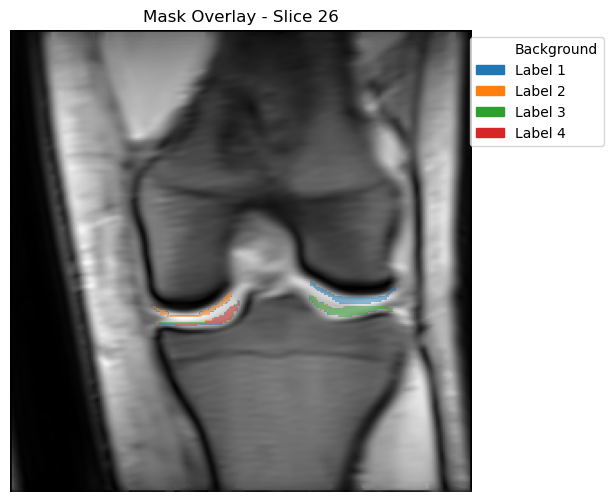

In [6]:
slice_index =26
show_mask(
    image=images[0],
    rois=rois,
    slice_index=slice_index,
    title=f"Mask Overlay - Slice {slice_index}",
    alpha=0.5
)